In [2]:
install.packages("xtable")
install.packages("hdm")
install.packages("glmnet")
install.packages("ggplot2")
install.packages("tidyr")
install.packages("MLmetrics")
install.packages("dplyr")
install.packages("readxl")

Warning message:
"package 'xtable' is in use and will not be installed"
Warning message:
"package 'hdm' is in use and will not be installed"
Warning message:
"package 'glmnet' is in use and will not be installed"
Warning message:
"package 'ggplot2' is in use and will not be installed"
Warning message:
"package 'tidyr' is in use and will not be installed"
Warning message:
"package 'MLmetrics' is in use and will not be installed"
Warning message:
"package 'dplyr' is in use and will not be installed"
Warning message:
"package 'readxl' is in use and will not be installed"


In [1]:
library(hdm)
library(xtable)
library(glmnet)
library(MLmetrics)
library(ggplot2)
library(tidyr)
library(dplyr)
library(readxl)

Cargando paquete requerido: Matrix

Loaded glmnet 4.1-10


Adjuntando el paquete: 'MLmetrics'


The following object is masked from 'package:base':

    Recall



Adjuntando el paquete: 'tidyr'


The following objects are masked from 'package:Matrix':

    expand, pack, unpack



Adjuntando el paquete: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
file <- "../input/Districtwise_literacy_rates.xlsx"
df <- read_excel("../input/Districtwise_literacy_rates.xlsx")

In [5]:
dim(df)

[1] 680 100

In [6]:
df <- na.omit(df)
dim(df)

[1] 625 100

In [7]:
cols_to_drop <- c("STATCD", "DISTCD", "STATNAME", 
                  "DISTNAME", "DISTRICTS", "BLOCKS", "VILLAGES")

# borrar columnas manuales
df <- df[, !(names(df) %in% cols_to_drop)]

# borrar columnas que solo tienen ceros
df <- df[, colSums(df != 0) > 0]
dim(df)


[1] 625  88

1 point → Create a histogram of the female and male literacy rate and comment briefly on its distribution.

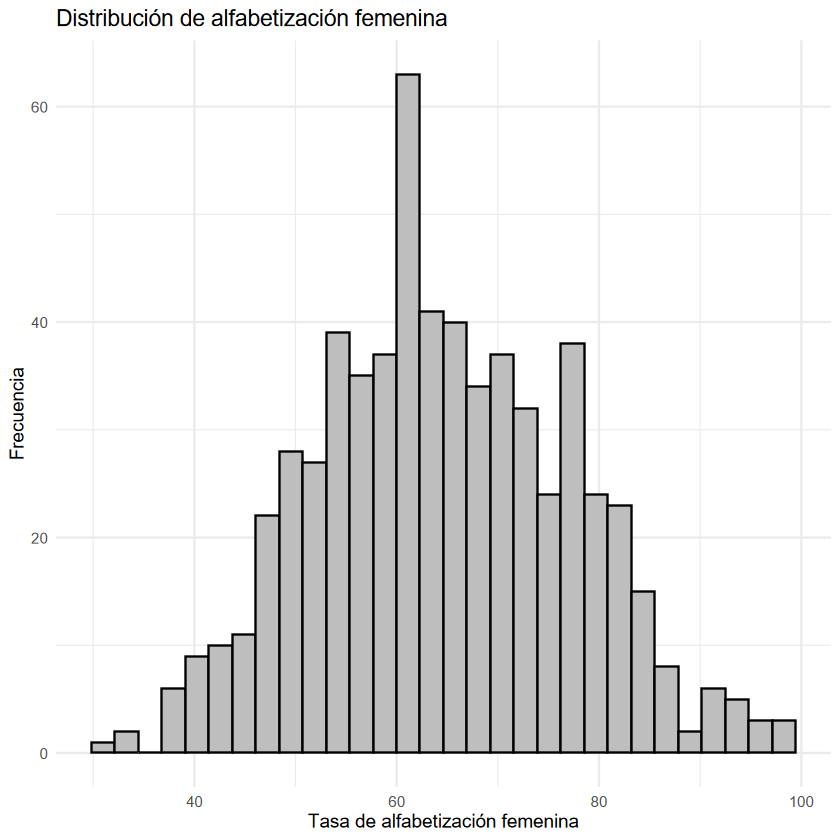

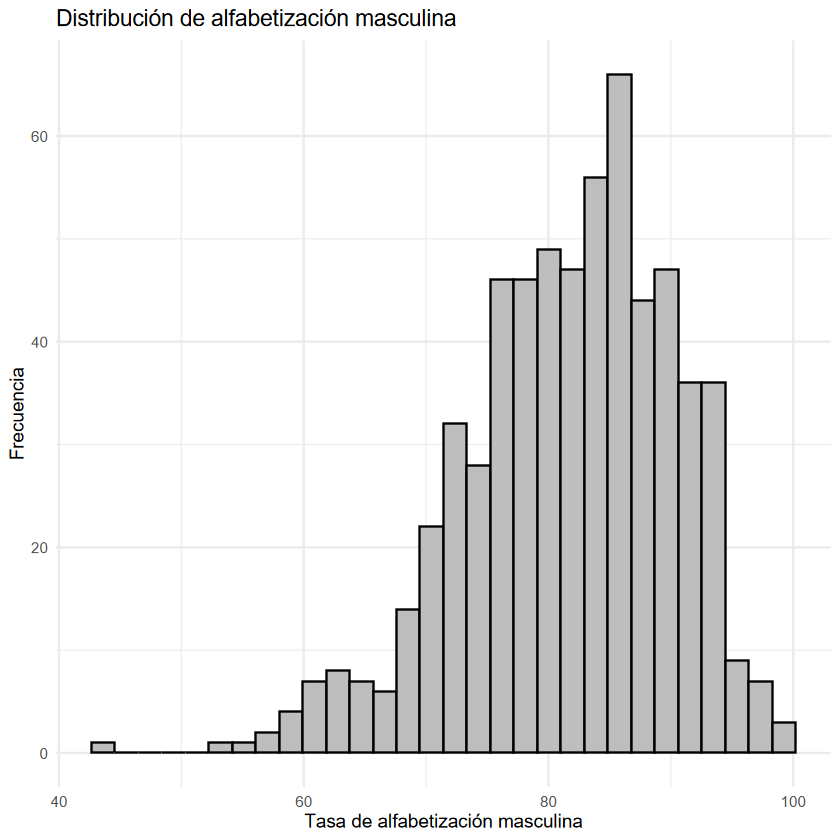

In [8]:

# Histograma de alfabetización femenina
ggplot(df, aes(x = FEMALE_LIT)) + 
  geom_histogram(bins = 30, fill = "grey", color = "black") + 
  theme_minimal() +
  labs(title = "Distribución de alfabetización femenina",
       x = "Tasa de alfabetización femenina",
       y = "Frecuencia")

# Histograma de alfabetización masculina
ggplot(df, aes(x = MALE_LIT)) + 
  geom_histogram(bins = 30, fill = "grey", color = "black") + 
  theme_minimal() +
  labs(title = "Distribución de alfabetización masculina",
       x = "Tasa de alfabetización masculina",
       y = "Frecuencia")


La tasa de alfabetización femenina presenta una distribución cercana a la normal, con mayor concentración en el rango del 60% al 65%. No obstante, se observa una cola izquierda más cargada, lo que indica que existen varios distritos con tasas de alfabetización femenina bajas, por otro lado, la alfabetización masculina se concentra principalmente entre el 80% y 90%, mostrando un sesgo hacia valores más altos. Esto refleja que, en promedio, los hombres alcanzan mayores niveles de alfabetización que las mujeres, evidenciando clara disparidad de género.

### Low dimensional specification (basic)

In [9]:
df <- df[, !(names(df) %in% c('OVERALL_LIT','MALE_LIT'))]


In [10]:
dim(df)

[1] 625  87

In [11]:
set.seed(1234)

# -------- 1) Split train/test --------
n <- nrow(df)
training <- sample(1:n, round(n * (3/4)), replace = FALSE)
data_train <- df[training, ]
data_test  <- df[-training, ]

In [12]:
vars20 <- c(
  "TOTPOPULAT","P_URB_POP","GROWTHRATE","SEXRATIO","AREA_SQKM",
  "SCHTOT","SCH1","SCH6","SCHTOTG","TOT_11_13_15","SCOMP5",
  "SCH1GR","SCH6GR","SCH1PR","SCH6PR",
  "ENR501","ENR506","ENR509",
  "TCH1","TCH6"
)

In [13]:

x_basic <- paste(vars20, collapse = " + ")
formula_basic <- as.formula(paste("FEMALE_LIT ~", x_basic))


In [14]:
y_train <- data_train$FEMALE_LIT
y_test  <- data_test$FEMALE_LIT

model_x_basic_train <- model.matrix(formula_basic, data_train)
model_x_basic_test  <- model.matrix(formula_basic, data_test)

p_basic <- dim(model_x_basic_train)[2]
cat("Número de predictores:", p_basic, "\n")

Número de predictores: 21 


In [15]:
# -------- 4) Ajuste OLS --------
fit_lm_basic <- lm(formula_basic, data_train)

# -------- 5) MSE OOS --------
yhat_lm_basic <- predict(fit_lm_basic, newdata = data_test)
mse_oos <- mean((y_test - yhat_lm_basic)^2)
cat("Basic model MSE (OLS):", mse_oos, "\n")


Basic model MSE (OLS): 85.63532 


In [ ]:
# -------- 6) R² OOS --------
mse_test <- mean((y_test - yhat_lm_basic)^2)
r2_oos <- 1 - mse_test / var(y_test)
cat("Basic model R^2 (OLS):", r2_oos, "\n")

Basic model R^2 (OLS): 0.4333367 


### High-dimensional specification (flexible)

In [19]:
# --- Construcción de la especificación flexible ---
x_flex <- paste(
  paste(vars20, collapse = " + "),
  ", (", paste(vars20, collapse = " + "), ") * (", paste(vars20, collapse = " + "), ")"
)

formula_flex <- as.formula(paste("FEMALE_LIT ~", paste(vars20, collapse = " + "),
                                 "+ (", paste(vars20, collapse = " + "), ") * (", paste(vars20, collapse = " + "), ")"))

# --- Matrices de diseño ---
model_x_flex_train <- model.matrix(formula_flex, data_train)
model_x_flex_test  <- model.matrix(formula_flex, data_test)

# --- Número de predictores ---
p_flex <- dim(model_x_flex_train)[2]
p_flex



[1] 211

In [20]:
# ols (flexible model)
fit_lm_flex <- lm(formula_flex, data_train)

In [21]:
# Compute the Out-Of-Sample Performance
options(warn = -1)
yhat_lm_flex <- predict(fit_lm_flex, newdata = data_test)
mse_lm_flex <- summary(lm((y_test - yhat_lm_flex)^2 ~ 1))$coef[1:2]
r2_lm_flex <- 1 - mse_lm_flex[1] / var(y_test)
cat("Flexible model R^2 (OLS): ", r2_lm_flex) 

Flexible model R^2 (OLS):  -18.14089

### Penalized regressions (flexible model)

In [22]:
fit_lasso_cv_flex <- cv.glmnet(model_x_flex_train, y_train, family = "gaussian", alpha = 1)
yhat_lasso_cv_flex <- predict(fit_lasso_cv_flex, newx = model_x_flex_test)
mse_lasso_cv_flex <- summary(lm((y_test - yhat_lasso_cv_flex)^2 ~ 1))$coef[1:2]
r2_lasso_cv_flex <- 1 - mse_lasso_cv_flex[1] / var(y_test)
cat("Flexible model R^2 (Lasso): ", r2_lasso_cv_flex)

Flexible model R^2 (Lasso):  0.4997539

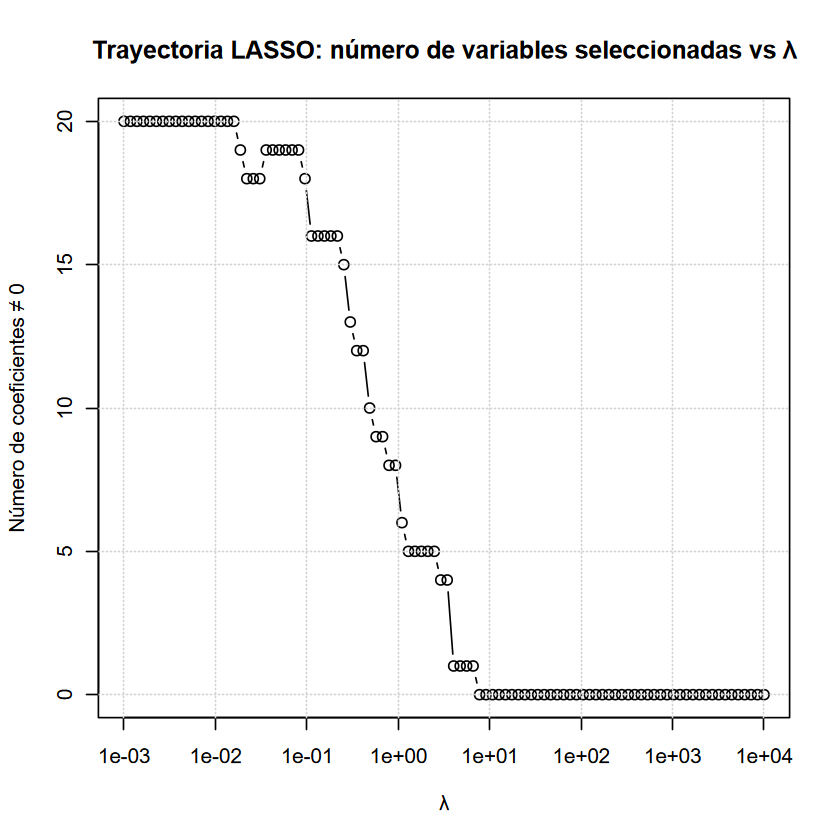

In [24]:
library(glmnet)

# X e y para glmnet (asegúrate que X_train no tenga la columna de intercepto duplicada)
X_train <- model_x_basic_train[, -1]   # quita intercepto
y_train <- data_train$FEMALE_LIT

# Rango de lambdas (de 10,000 a 0.001 en escala log)
lambdas <- exp(seq(log(1e4), log(1e-3), length.out = 100))

nonzero_counts <- numeric(length(lambdas))

for (i in seq_along(lambdas)) {
  fit <- glmnet(X_train, y_train, alpha = 1, lambda = lambdas[i], standardize = TRUE)
  nonzero_counts[i] <- sum(coef(fit) != 0) - 1  # restar intercepto
}

# Plot
plot(lambdas, nonzero_counts, type = "b", log = "x",
     xlab = expression(lambda),
     ylab = "Número de coeficientes ≠ 0",
     main = "Trayectoria LASSO: número de variables seleccionadas vs λ")
grid()
